In [1]:
#importing the python libraries
import numpy as np
import pandas as pd
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [2]:
#importing needed python libraries
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from imblearn.over_sampling import SMOTE
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
import re
from textblob import TextBlob
sns.set_style('white')
%matplotlib inline
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [3]:
#Loading the data into datframe
review_df=pd.read_csv('/drive/MyDrive/Sentiment Analysis/sample30.csv')

#Exploratory Data Analysis

In [4]:
#Getting to know the data set by chekcing its shape, attributes, kind of data in it
review_df.shape

(30000, 15)

So, we have a total of 15 features in our dataset and it has 30,000 reviews stored in it

In [5]:
#checking the Dataset columns
review_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

Since, we dont have any numerical column, therefore doing the review_df.describe() will not do any help

In [6]:
#Seeing the data stored in the dataframe
review_df.head(5)

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


So, as shown above, our review dataframe has the manufacturer, category, review text, review title, review_date, review_rating, recommended or not, review_province, sentiment and other details to help us do our analysis and do the recommendation

In [7]:
review_df['name'].value_counts()

Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                         8545
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                   3325
Clorox Disinfecting Bathroom Cleaner                                              2039
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1186
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)               1143
                                                                                  ... 
Fantasy Fields Lil' Sports Fan Step Stool - Teamson                                  1
Black Sister's Revenge (dvd)                                                         1
Iman Luxury Moisturizing Lipstick, Black Brandy 006                                  1
Tostitos Original Restaurant Style Tortilla Chips                                    1
Noosa Honey Yogurt                                                                   1
Name: name, Length: 271, dtype: int64

In [8]:
review_df.groupby('name')['reviews_rating'].count().sort_values(ascending=False).head()

name
Clorox Disinfecting Wipes Value Pack Scented 150 Ct Total                         8545
Godzilla 3d Includes Digital Copy Ultraviolet 3d/2d Blu-Ray/dvd                   3325
Clorox Disinfecting Bathroom Cleaner                                              2039
L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz    1186
Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd)               1143
Name: reviews_rating, dtype: int64

Above, are the top products for which users had given the most ratings

In [9]:
ratings = pd.DataFrame(review_df.groupby('name')['reviews_rating'].mean())
ratings.head()

,reviews_rating
name,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,4.166667
100:Complete First Season (blu-Ray),4.712230
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,5.000000
"2x Ultra Era with Oxi Booster, 50fl oz",4.800000
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",5.000000


In [10]:
ratings['num of ratings'] = pd.DataFrame(review_df.groupby('name')['reviews_rating'].count())
ratings.head()

,reviews_rating,num of ratings
name,,
0.6 Cu. Ft. Letter A4 Size Waterproof 30 Min. Fire File Chest,4.166667,6
100:Complete First Season (blu-Ray),4.712230,139
2017-2018 Brownline174 Duraflex 14-Month Planner 8 1/2 X 11 Black,5.000000,4
"2x Ultra Era with Oxi Booster, 50fl oz",4.800000,5
"42 Dual Drop Leaf Table with 2 Madrid Chairs""",5.000000,1


In [11]:
round((review_df['user_sentiment'].value_counts()/len(review_df.index))*100,2)

Positive    88.77
Negative    11.22
Name: user_sentiment, dtype: float64

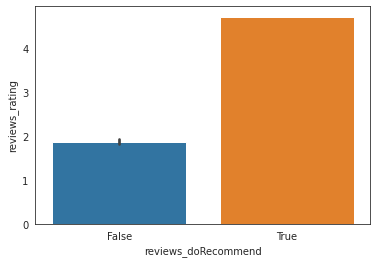

In [12]:
sns.barplot(x=review_df['reviews_doRecommend'],y=review_df['reviews_rating'])

As above, Low rated products were not recommended

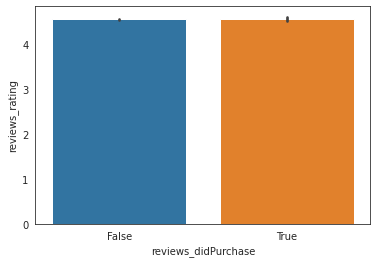

In [13]:
sns.barplot(x=review_df['reviews_didPurchase'],y=review_df['reviews_rating'])

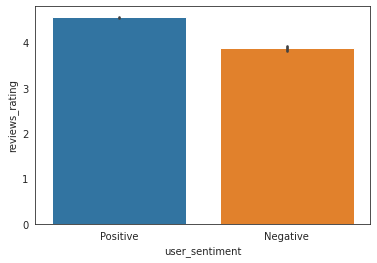

In [14]:
sns.barplot(x=review_df['user_sentiment'],y=review_df['reviews_rating'])

The user sentiment for most of the data points we have is as per the rating, Low ragted product, bad review, and hence negative sentiment otherwise positive

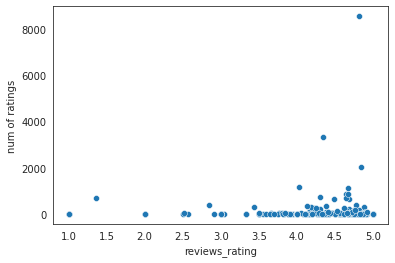

In [15]:
sns.scatterplot(x=ratings['reviews_rating'],y=ratings['num of ratings'])

We, will now, focus on the null values in our data and then moving forward to our data pre-processing

#Data Preprocessing

In [16]:
# Finding out the missing values per column
missing = round(100*(review_df.isnull().sum()/len(review_df.index)), 2)
missing.loc[missing >= 0]

id                       0.00
brand                    0.00
categories               0.00
manufacturer             0.47
name                     0.00
reviews_date             0.15
reviews_didPurchase     46.89
reviews_doRecommend      8.57
reviews_rating           0.00
reviews_text             0.00
reviews_title            0.63
reviews_userCity        93.57
reviews_userProvince    99.43
reviews_username         0.21
user_sentiment           0.00
dtype: float64

From the above, results it is clear that we have 14 independent variables and one dependent variable whichi is user_sentiment, and rest others which have higher importance can be used for analysis rest can be dropped off.

Generally, we consider if the null % >70%, we drop that column

In [17]:
#Taking a copy of original dataframe and making changes to that for further analysis

data = copy.deepcopy(review_df)

In [18]:
data.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative



Dropping the following columns from the dataset:
- reviews_userProvince - Null % too high
- reviews_userCity - Null% too high
- review_date - seems unimportant to decide the sentiment
- brand, categories,manufacturer - These are not needed, as We have product name which is sufficient to predict sentiment 

In [19]:
data.drop(['reviews_userProvince','reviews_userCity','reviews_date','brand','categories','manufacturer'],axis=1,inplace=True)

In [20]:
data.shape

(30000, 9)

We now have total 30000 reviews and 9 columns

In [21]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   id                   30000 non-null  object
 1   name                 30000 non-null  object
 2   reviews_didPurchase  15932 non-null  object
 3   reviews_doRecommend  27430 non-null  object
 4   reviews_rating       30000 non-null  int64 
 5   reviews_text         30000 non-null  object
 6   reviews_title        29810 non-null  object
 7   reviews_username     29937 non-null  object
 8   user_sentiment       29999 non-null  object
dtypes: int64(1), object(8)
memory usage: 2.1+ MB


# Text Preprocessing

While doing text preprocessing, let us first convert all the text to lowercase

In [22]:
pd.set_option("display.max_colwidth", -1)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [23]:
data['reviews_text']

0        i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
1        Good flavor. This review was collected as part of a promotion.                                                                                                                                                                                                                               

 The string "This review was collected as a part of promotion is being used repetitively, hence stripping that from our string

In [24]:
data['reviews_text']=data['reviews_text'].str.replace("This review was collected as part of a promotion.","")

In [25]:
data['reviews_text']=data['reviews_text'].str.lower()

In [26]:
data['reviews_title']

0        Just Awesome               
1        Good                       
2        Good                       
3        Disappointed               
4        Irritation                 
            ...                     
29995    Softness!!                 
29996    I love it                  
29997    Hair is so smooth after use
29998    Perfect for my oily hair!  
29999    Conditioned into healthy   
Name: reviews_title, Length: 30000, dtype: object

Converting all string columns to lowercase

In [27]:
data['reviews_title']=data['reviews_title'].str.lower()
data['reviews_username']=data['reviews_username'].str.lower()
data['name']=data['name'].str.lower()

In [28]:
data.head()

,id,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,pink friday: roman reloaded re-up (w/dvd),NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. so hype! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,just awesome,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,lundberg organic cinnamon toast rice cakes,True,NaN,5,good flavor.,good,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,lundberg organic cinnamon toast rice cakes,True,NaN,5,good flavor.,good,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,k-y love sensuality pleasure gel,False,False,1,"i read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews i had read. for starters, neither my boyfriend nor i could notice any sort of enhanced or 'captivating' sensation. what we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. it was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. i'm disappointed that i paid as much as i did for a lube that i won't use again, when i could just use their normal personal lubricant for 1) less money and 2) less mess.",disappointed,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,k-y love sensuality pleasure gel,False,False,1,my husband bought this gel for us. the gel caused irritation and it felt like it was burning my skin. i wouldn't recommend this gel.,irritation,walker557,Negative


In [29]:
#analyzing the data in review column as per user_sentiment
rating_3 = data[data['reviews_rating']>3]

In [30]:
rating_3=rating_3[rating_3['user_sentiment']=='Negative']

In [31]:
len(rating_3['id'])

2410

As formt he above, we can see that even though the user has rated the product 4 or 5 and with good reviews, the user_sentiment is still Negative. This is a rare case and does not fits best to the users general behaviour. Hence, we can delete such records from our dataset.
These are 2410 records out of the total 30K records.Removing these records, we still have a good enough amount of data to do the training

In [32]:
data.shape

(30000, 9)

In [33]:
#filtering out those which have a rating ># and still the senitment is Negative
data = data[((data.reviews_rating>3) & (data.user_sentiment=='Negative'))==False]

In [34]:
#Fitlering out those where the user_Sentiment is null
data=data[data['user_sentiment'].isnull()==False]

In [35]:
data.shape

(27589, 9)

Removed a bove are the records with high rating and negative yser_sentiment, there me some records as well where rating is 1 and user_sentiment is positive, let's check on those review_text

In [36]:
rating_1 = data[data['reviews_rating']==1]

In [37]:
rating_1=rating_1[rating_1['user_sentiment']=='Positive']

In [38]:
rating_1

,id,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
9,AV16khLE-jtxr-f38VFn,k-y love sensuality pleasure gel,False,False,1,got as a surprise for my husband there is nothing special about it just a lube save the money and get plain ky if you just need a lube wish i could return it for a refund,don't buy,moore222,Positive
11,AV16khLE-jtxr-f38VFn,k-y love sensuality pleasure gel,False,False,1,purchased this thinking it would have some sort of warming effect but it's the same as the original. don't waste your money.,waste of money,bre234,Positive
14,AV16khLE-jtxr-f38VFn,k-y love sensuality pleasure gel,False,False,1,first time purchase of this type of product. maybe i expected too much. did not think there was any warming feeling at all. left us sticky! even after trying to was it off.,disappointed,nicole,Positive
54,AV1l8zRZvKc47QAVhnAv,olay regenerist deep hydration regenerating cream,False,False,1,"i used (and loved) this product for several years until they changed it. it used to moisturize my skin and left it feeling soft. now, it sits on top of my skin and is never absorbed. it just leaves a slimy film on my skin. i will no longer purchase this product.",new formula is terrible,alnscoob97,Positive
56,AV1l8zRZvKc47QAVhnAv,olay regenerist deep hydration regenerating cream,False,False,1,"i am so disappointed! i have used this product for years because of it's soft smell and great results. the new formula feels greasy, smells awful and i don't feel like my skin looks as toned and wrinkle free anymore. this was a five star product for so many years...why change it please bring back the old formula.",please bring back the old formula,jacmary,Positive
...,...,...,...,...,...,...,...,...,...
28831,AVpfW8y_LJeJML437ySW,l'or233al paris elvive extraordinary clay rebalancing conditioner - 12.6 fl oz,NaN,NaN,1,i'm happy i got to try this courtesy of influenster but i really didn't like it. it didn't condition my hair at all. not worth purchasing.,not good,neighha,Positive
28832,AVpfW8y_LJeJML437ySW,l'or233al paris elvive extraordinary clay rebalancing conditioner - 12.6 fl oz,NaN,True,1,i can see this working amazingly for someone with normal thickness and coarseness. between the mask and shampoo it was too much for my already dry damaged ends. i did receive this product for free in exchange for a review however all opinions are my own.,wrong for me,nmm2592,Positive
28833,AVpfW8y_LJeJML437ySW,l'or233al paris elvive extraordinary clay rebalancing conditioner - 12.6 fl oz,NaN,NaN,1,"when i got these products in the mail i was actually really excited about them! but once i used them i notice that they didn't really make a difference in my oily roots or my dry ends! on the contrary i feel like my roots became more oily and my hair and ends became extremely dry! i wasn't too happy with these products. beware of your hair becoming very tangled!! (if you have curly hair). as far as the conditioner, it smelled kind of good actually and it felt like it conditioned my hair while i applied it in the shower. but out of the shower, my hair was a completely different story! very tangled and dry ends! *i received these products complimentary from influenster but all the reviews are my own thoughts*",nothing extraordinary about it!,kimberlyp721,Positive
28834,AVpfW8y_LJeJML437ySW,l'or233al paris elvive extraordinary clay rebalancing conditioner - 12.6 fl oz,NaN,NaN,1,i was so excited about receiving this free to use and write a review... my excitement ended there....in my opinion makes my roots more greasy and my ends dull.,makes my hair worse,rachie0814,Positive


Here again analyzing the review_text and review_title along with the rating, we see that the user_senitment is not correct. It cannot be positive.Therefore, removing these 787 rows from our dataset

In [39]:
#Filterign out those where the rating=1 and user_sentiment is Positive
data = data[((data.reviews_rating==1) & (data.user_sentiment=='Positive'))==False]

In [40]:
data.shape

(26802, 9)

In [41]:
#analyzing the english stopwords
stop=stopwords.words('english')

In [42]:
## initialise the inbuilt Stemmer and the Lemmatizer
stemmer = PorterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

In [43]:
excluding = ['against','not','don', "don't",'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't",
             'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 
             'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't",'shouldn', "shouldn't", 'wasn',
             "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]
stop = [words for words in stop if words not in excluding]
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'only', 'own', 'same', 'so', 'than', 'too', 'very', 's',

In [44]:
data['reviews_text']=data['reviews_text'].apply(str)

In [45]:
data['reviews_title']=data['reviews_title'].apply(str)

In [46]:
data_set = []
for index,row in data.iterrows():
    data_set.append((data['reviews_text'], data['reviews_title']))

NOw, concatenating, reviews_text and reviews_title as they both similarly predict the user_senitment, and we just need a bag of words with words indicating positive and negative senitment for our model to predict and recommend better products

In [47]:
data['review']=data['reviews_text']+data['reviews_title']

In [48]:
data.head(2)

,id,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review
0,AV13O1A8GV-KLJ3akUyj,pink friday: roman reloaded re-up (w/dvd),NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. so hype! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,just awesome,joshua,Positive,i love this album. it's very good. more to the hip hop side than her current pop sound.. so hype! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.just awesome
1,AV14LG0R-jtxr-f38QfS,lundberg organic cinnamon toast rice cakes,True,NaN,5,good flavor.,good,dorothy w,Positive,good flavor. good


NOw, we will follwo soem general steps for text preprocessing.Ideally, a good pre processed text is:
- All in lowercases
- Stripping punctuations
- Stopwords Removed
- Stemming
- Lemmatization

In [49]:
def preprocess(text, stem=True):
    'removes stopwords and lemmatizes/stems the remainder of the sentence'
    text = re.sub('[^a-z]+', ' ', text).strip()
    
    # tokenize into words
    words = word_tokenize(text)

    # remove stop words
    words = [word for word in words if word not in stopwords.words("english")]

    if stem:
        words = [stemmer.stem(word) for word in words]
    else:
        words = [wordnet_lemmatizer.lemmatize(word, pos='v') for word in words]

    # join words to make sentence
    text = " ".join(words)

    return text

In [50]:
## - Performing the preprocessing steps on all messages
data['review'] = [preprocess(review) for review in data['review']]
print(data['review'])

0        love album good hip hop side current pop sound hype listen everyday gym give star rate way metaphor crazi awesom                                                                                                                                                                                                                                          
1        good flavor good                                                                                                                                                                                                                                                                                                                                          
2        good flavor good                                                                                                                                                                                                                                                                       

#Feature Exrtraction

In [51]:
#Perforing vectorization of text using TF-IDF
vectorizer = TfidfVectorizer()

X_features = vectorizer.fit_transform(data['review'])
print(X_features)

  (0, 808)	0.13069945739025485
  (0, 2758)	0.2257516686986242
  (0, 7577)	0.3381176675436373
  (0, 13426)	0.1393891288411383
  (0, 9787)	0.22241894356671443
  (0, 11547)	0.1769828042437954
  (0, 5088)	0.16166718932403967
  (0, 5529)	0.2781210223989157
  (0, 4094)	0.1700413938646166
  (0, 7076)	0.23512606445015696
  (0, 6041)	0.2781210223989157
  (0, 11322)	0.19699298735457552
  (0, 9191)	0.22003831332155466
  (0, 2876)	0.23617254853169142
  (0, 10965)	0.19851144845946173
  (0, 5909)	0.30974609762335426
  (0, 5834)	0.32848470089168835
  (0, 5214)	0.09154582689959379
  (0, 317)	0.23033436629911067
  (0, 7190)	0.06843869755373218
  (1, 4576)	0.7188991933632765
  (1, 5214)	0.6951143429549057
  (2, 4576)	0.7188991933632765
  (2, 5214)	0.6951143429549057
  (3, 7556)	0.07974782940202665
  :	:
  (26800, 4426)	0.12392056651510729
  (26800, 9841)	0.11760550200755983
  (26800, 8233)	0.21557993707071887
  (26800, 13041)	0.07220865582801127
  (26800, 1616)	0.13474376158257742
  (26801, 2437)	0.2082

In [52]:
# print the full sparse matrix
print(X_features.toarray())

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [53]:
w=vectorizer.get_feature_names()

In [54]:
pd.DataFrame(X_features.toarray(), columns = vectorizer.get_feature_names())

,aaa,aaaaaaaaaaaaaaaaagreat,aaahhhhh,aaammmaaaz,aalot,aanyhwer,aaron,ab,abandon,abc,abcess,abd,abdomin,abil,abl,ablehair,abomin,abort,aboslut,abosolut,abou,aboutanoth,aboutawesom,abras,abrey,abroad,abruptli,absenc,abslut,absob,absolut,absolutey,absoluti,absolutley,absolutli,absorb,absout,abt,abund,abus,...,yumm,yummi,yummilici,yummm,yummmm,yummmmi,yummmthi,yummyyummi,yup,yyear,zac,zach,zack,zap,zep,zero,zest,zesti,zilla,zillah,zinc,zing,zion,zip,zipcod,ziploc,ziplock,zipper,zit,zittiragu,zojirushi,zombi,zombifi,zone,zoo,zoom,zorba,zow,zucchetta,zucchini
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26797,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26798,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26799,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
26800,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [55]:
#Let's see the text sentiment of some records using TextBlob
data['review'][:5].apply(lambda x: TextBlob(x).sentiment)

0    (0.28, 0.52)                              
1    (0.7, 0.6000000000000001)                 
2    (0.7, 0.6000000000000001)                 
3    (0.06422558922558921, 0.48055555555555557)
4    (0.0, 0.0)                                
Name: review, dtype: object

# Data Modelling
We will start with Train test split of the data first and then use SMOTE to overcome class imbalance on the training set

In [56]:
data.head(2)

,id,name,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review
0,AV13O1A8GV-KLJ3akUyj,pink friday: roman reloaded re-up (w/dvd),NaN,NaN,5,i love this album. it's very good. more to the hip hop side than her current pop sound.. so hype! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,just awesome,joshua,Positive,love album good hip hop side current pop sound hype listen everyday gym give star rate way metaphor crazi awesom
1,AV14LG0R-jtxr-f38QfS,lundberg organic cinnamon toast rice cakes,True,NaN,5,good flavor.,good,dorothy w,Positive,good flavor good


We are only using reviews_text and review_title as the feature for our sentiment analysis, and rest other columns for the reviews are not necessary hence


The column reviews_text and reviews_title are concatenated into one single column review- and preprocessed as well after vectorization and feature extraction, hence these two columns too can be dropped from our data set.

And, we will be considering the user_senitment as our target variable

In [57]:
data.drop(['reviews_didPurchase','reviews_doRecommend','reviews_title','reviews_text'],axis=1,inplace=True)

In [58]:
#since we combined reviews_text and reviews_title, and we are considering only these two as our features
X = data['review']

In [59]:
#the target variable will be user_sentiment
y = data['user_sentiment']

In [60]:
print(X.shape)
print(y.shape)

(26802,)
(26802,)


In [61]:
print('# features: {}'.format(X_features.shape[1]))

# features: 13970


In [62]:
#splitting data into train test
X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.2, random_state=43)

#Logistic Regression

In [63]:
#defining function to fit, predict, and see model's performance
def model_fit(X, y,ml_model):
    
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size = 0.2, random_state=43)
    clf = ml_model.fit(X_train, y_train)
    clf_pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    model_performance = classification_report(y_test, clf_pred)
    print ('accuracy of the model: ', accuracy)
    print('')
    print(model_performance)


In [64]:
#passing Logistic Regressioin to model_fit() to check the model's accuracy using LogisticRegression
model_fit(X, y,LogisticRegression())

accuracy of the model:  0.9774295840328296

              precision    recall  f1-score   support

    Negative       0.97      0.36      0.52       185
    Positive       0.98      1.00      0.99      5176

    accuracy                           0.98      5361
   macro avg       0.97      0.68      0.76      5361
weighted avg       0.98      0.98      0.97      5361



In [65]:
#checking the class imbalance
y.value_counts()

Positive    25845
Negative    957  
Name: user_sentiment, dtype: int64

If we check the above value counts, the target values are skewed towards positive side. In order to address this issue, resampling the data has to be performed. I will use oversampling to combat class imbalance. Smote is especially preferable since it's a well-made package with it's own pipeline function compatible with other python modules. Also, before applying SMOTE technique to balance the class

In [66]:
#using SMOTE to overcome class imbalance
smote = SMOTE()

# fit predictor and target variable
X_train_smote, y_train_smote = smote.fit_sample(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [67]:
#now we have declared another function to chk the accuracy of models after the data is balanced
def class_balanced_model_fit(X_train_smote, y_train_smote, X_test, y_test, ml_model):
    
    clf = ml_model.fit(X_train_smote, y_train_smote)
    clf_pred = clf.predict(X_test)
    accuracy = clf.score(X_test, y_test)
    model_performance = classification_report(y_test, clf_pred)
    validation_pred_proba_grad = clf.predict_proba(X_test)
    roc_auc = roc_auc_score(y_test, validation_pred_proba_grad[:,1])
    
    print ('accuracy of the model: ', accuracy)
    print('')
    print(model_performance)
    print('')
    print('ROC_AUC score: ', roc_auc)

In [68]:
#LR on SMOTe balanced data
class_balanced_model_fit(X_train_smote, y_train_smote, X_test, y_test, LogisticRegression())

accuracy of the model:  0.9673568364111174

              precision    recall  f1-score   support

    Negative       0.52      0.74      0.61       185
    Positive       0.99      0.98      0.98      5176

    accuracy                           0.97      5361
   macro avg       0.75      0.86      0.80      5361
weighted avg       0.97      0.97      0.97      5361


ROC_AUC score:  0.9673367726304357


##Predicting the LR on the entire data set.

In [69]:
logit = LogisticRegression()
logit.fit(X_train_smote, y_train_smote)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [70]:
predict_test = logit.predict(X_features )

In [71]:
y_test_pred=pd.DataFrame(predict_test, columns=['Predicted'])
y_test_actual=pd.DataFrame(data.user_sentiment).reset_index(drop=True)
y_test_pred['Actual']=y_test_actual.user_sentiment
y_test_pred.head()

,Predicted,Actual
0,Positive,Positive
1,Positive,Positive
2,Positive,Positive
3,Negative,Negative
4,Negative,Negative


In [72]:

print(metrics.accuracy_score(y_test_pred.Actual, y_test_pred.Predicted))

0.9808969479889561


Logistic Regression gave us a 98% accuracy on the balanced data

In [73]:
#adding the predicted suer sentiment column in our original dataframe so that it can help in recommendation system
data['user_sentiment_pred']=y_test_pred['Predicted']

In [74]:
data.head(1)

,id,name,reviews_rating,reviews_username,user_sentiment,review,user_sentiment_pred
0,AV13O1A8GV-KLJ3akUyj,pink friday: roman reloaded re-up (w/dvd),5,joshua,Positive,love album good hip hop side current pop sound hype listen everyday gym give star rate way metaphor crazi awesom,Positive


In [75]:
data.to_csv("prod_with_pred.csv",index=False)

Since, we chose Logistice Regression as the best, hence, saving these predictions into csv

#Naive Bayes Modeling:

In [76]:
class_balanced_model_fit(X_train_smote, y_train_smote, X_test, y_test, MultinomialNB())

accuracy of the model:  0.9382577877261705

              precision    recall  f1-score   support

    Negative       0.33      0.77      0.46       185
    Positive       0.99      0.94      0.97      5176

    accuracy                           0.94      5361
   macro avg       0.66      0.86      0.72      5361
weighted avg       0.97      0.94      0.95      5361


ROC_AUC score:  0.9362055641421947


In [77]:
class_balanced_model_fit(X_train_smote, y_train_smote, X_test, y_test, BernoulliNB())

accuracy of the model:  0.9501958589815332

              precision    recall  f1-score   support

    Negative       0.35      0.54      0.43       185
    Positive       0.98      0.96      0.97      5176

    accuracy                           0.95      5361
   macro avg       0.67      0.75      0.70      5361
weighted avg       0.96      0.95      0.96      5361


ROC_AUC score:  0.8924161410251056


Accuracy of 94% is obtained by the Naive Bayes

# XGBoost

In [78]:
#### Fitting a XGBoost classifier without any hyperparameter tuning

class_balanced_model_fit(X_train_smote, y_train_smote, X_test, y_test, XGBClassifier(booster='gbtree'))


accuracy of the model:  0.9535534415221041

              precision    recall  f1-score   support

    Negative       0.39      0.62      0.48       185
    Positive       0.99      0.97      0.98      5176

    accuracy                           0.95      5361
   macro avg       0.69      0.79      0.73      5361
weighted avg       0.97      0.95      0.96      5361


ROC_AUC score:  0.940104536530348


95% accuracy obtained by XGBoost 

#Random Forest algorithm

In [79]:
# Random forest
# Running the random forest with default parameters.
class_balanced_model_fit(X_train_smote, y_train_smote, X_test, y_test,RandomForestClassifier(class_weight='balanced'))


accuracy of the model:  0.9802275694833054

              precision    recall  f1-score   support

    Negative       0.91      0.48      0.62       185
    Positive       0.98      1.00      0.99      5176

    accuracy                           0.98      5361
   macro avg       0.94      0.74      0.81      5361
weighted avg       0.98      0.98      0.98      5361


ROC_AUC score:  0.9266484606708718


97% accuracy given by Random Forest, still we decide on the hyperparameter tuning on the Random Forest

Let's try on frther doing hyper parameter tuning on this

# Hyperparameter Tuning on Random Forest

In [80]:
# GridSearchCV to find optimal n_estimators
# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')




# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True,n_jobs=-1)
rf.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              r

In [81]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.837956,0.038782,0.186521,0.004295,2,{'max_depth': 2},0.786164,0.849299,0.806362,0.804040,0.827628,0.814698,0.021733,4,0.802298,0.843090,0.805806,0.809229,0.822775,0.816640,0.014935
1,4.316398,0.008063,0.207083,0.015847,7,{'max_depth': 7},0.855467,0.874456,0.873367,0.868030,0.862465,0.866757,0.007078,3,0.873299,0.870668,0.876625,0.870158,0.863082,0.870767,0.004476
2,7.266908,0.067555,0.219374,0.009390,12,{'max_depth': 12},0.877479,0.899855,0.901790,0.882545,0.895125,0.891359,0.009649,2,0.903508,0.902480,0.904173,0.888422,0.901636,0.900044,0.005875
3,10.090124,0.721138,0.224536,0.035755,17,{'max_depth': 17},0.905539,0.929971,0.925375,0.926697,0.931051,0.923727,0.009327,1,0.934986,0.936498,0.931267,0.931965,0.935261,0.933995,0.002021


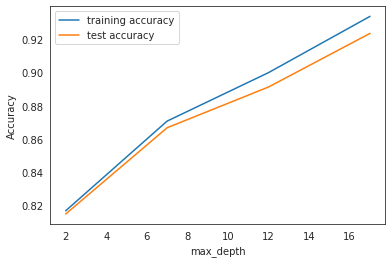

In [82]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [83]:
# Tuning n_estimators
# GridSearchCV to find optimal n_estimators

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'n_estimators': range(100, 1500, 400)}

# instantiate the model (note we are specifying a max_depth)
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                  cv=n_folds, 
                  scoring="accuracy", 
                  return_train_score=True,
                  n_jobs=-1)

In [84]:
rf.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              r

In [85]:

# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,6.035980,0.045916,0.227657,0.016654,100,{'n_estimators': 100},0.866594,0.880503,0.888365,0.880973,0.887988,0.880885,0.007884,4,0.891745,0.881191,0.895313,0.882525,0.892050,0.888565,0.005633
1,29.529523,0.230063,0.893725,0.014369,500,{'n_estimators': 500},0.866352,0.888244,0.887881,0.887142,0.885085,0.882941,0.008366,3,0.890293,0.888993,0.891987,0.891264,0.890599,0.890627,0.001004
2,52.864728,0.235823,1.549226,0.022183,900,{'n_estimators': 900},0.871553,0.891026,0.887276,0.888230,0.889682,0.885553,0.007115,1,0.893166,0.891140,0.892833,0.889389,0.893320,0.891970,0.001506
3,74.390335,6.624771,2.087654,0.288727,1300,{'n_estimators': 1300},0.873246,0.891993,0.888365,0.886900,0.883876,0.884876,0.006375,2,0.895706,0.892803,0.893468,0.890508,0.888815,0.892260,0.002390


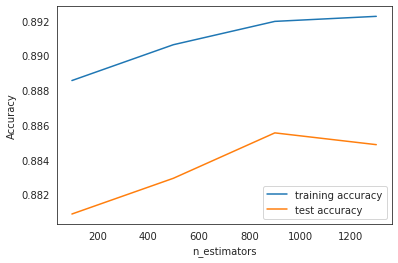

In [86]:
# plotting accuracies with n_estimators
plt.figure()
plt.plot(scores["param_n_estimators"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_n_estimators"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [87]:
# GridSearchCV to find optimal max_features

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_features': [4, 8, 14, 20, 24]}

# instantiate the model
rf = RandomForestClassifier(max_depth=10, class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True)
rf.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=10,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                              r

In [88]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_features,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.347604,0.031695,0.127889,0.004067,4,{'max_features': 4},0.842646,0.873125,0.869860,0.853514,0.859441,0.859717,0.011069,5,0.863048,0.870699,0.879256,0.853346,0.857761,0.864822,0.009248
1,1.649173,0.023853,0.128626,0.005320,8,{'max_features': 8},0.831640,0.898403,0.859216,0.867304,0.893916,0.870096,0.024387,2,0.861173,0.900756,0.866344,0.874029,0.895528,0.879566,0.015796
2,1.912840,0.020667,0.129448,0.004042,14,{'max_features': 14},0.864901,0.882317,0.858732,0.863191,0.875166,0.868862,0.008617,3,0.890686,0.881101,0.861929,0.870128,0.872547,0.875278,0.009834
3,2.069268,0.021733,0.128172,0.003512,20,{'max_features': 20},0.853653,0.893687,0.860063,0.878311,0.881456,0.873434,0.014618,1,0.881282,0.894073,0.864197,0.885156,0.882646,0.881471,0.009718
4,2.181005,0.013025,0.130977,0.002837,24,{'max_features': 24},0.836236,0.869497,0.864780,0.873352,0.863675,0.861508,0.013101,4,0.864651,0.865951,0.867161,0.877173,0.864050,0.867797,0.004810


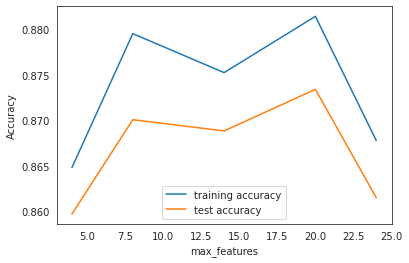

In [89]:
# plotting accuracies with max_features
plt.figure()
plt.plot(scores["param_max_features"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_features"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_features")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [90]:

# GridSearchCV to find optimal min_samples_leaf

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(100, 400, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy", return_train_score=True,n_jobs=-1)
rf.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [91]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,7.761021,0.215974,0.223802,0.004391,100,{'min_samples_leaf': 100},0.881108,0.900581,0.896468,0.900085,0.893674,0.894383,0.007099,1,0.898639,0.894194,0.898942,0.896193,0.891567,0.895907,0.002776
1,5.839803,0.355510,0.213989,0.019441,150,{'min_samples_leaf': 150},0.857281,0.887034,0.871795,0.874320,0.874803,0.873047,0.009492,2,0.873813,0.881917,0.870729,0.874543,0.870854,0.874371,0.004072
2,4.802095,0.115945,0.199594,0.006289,200,{'min_samples_leaf': 200},0.845912,0.871069,0.862845,0.855933,0.869360,0.861024,0.009252,3,0.861294,0.865225,0.862806,0.856763,0.864473,0.862112,0.003001
3,3.982411,0.138050,0.201644,0.007908,250,{'min_samples_leaf': 250},0.835389,0.848452,0.854862,0.864764,0.860288,0.852751,0.010252,4,0.850438,0.845721,0.856728,0.859968,0.855432,0.853658,0.005015
4,3.504788,0.072830,0.193940,0.009986,300,{'min_samples_leaf': 300},0.838050,0.859337,0.847726,0.843837,0.846861,0.847162,0.006967,6,0.856002,0.851315,0.846235,0.841432,0.843398,0.847677,0.005328


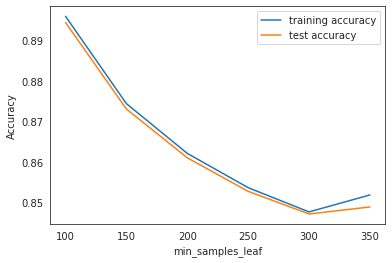

In [92]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [93]:
# GridSearchCV to find optimal min_samples_split

# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(200, 500, 50)}

# instantiate the model
rf = RandomForestClassifier(class_weight='balanced')


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                  cv=n_folds, 
                  scoring="accuracy",
                  return_train_score=True)
rf.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [94]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,17.907346,0.436402,0.279725,0.004257,200,{'min_samples_split': 200},0.977504,0.987905,0.986212,0.989234,0.986815,0.985534,0.004145,1,0.997309,0.996523,0.996553,0.996674,0.996492,0.996710,0.000306
1,17.045857,0.262376,0.278628,0.012167,250,{'min_samples_split': 250},0.972545,0.985123,0.982825,0.986573,0.984275,0.982268,0.005011,2,0.994859,0.993589,0.993862,0.994043,0.994285,0.994128,0.000431
2,16.532258,0.236500,0.270486,0.005673,300,{'min_samples_split': 300},0.970851,0.983188,0.981616,0.984759,0.981130,0.980309,0.004897,3,0.992380,0.991140,0.991956,0.991110,0.992471,0.991811,0.000587
3,16.568702,1.084460,0.271869,0.009179,350,{'min_samples_split': 350},0.967586,0.980164,0.978713,0.981735,0.978590,0.977358,0.005018,4,0.990354,0.989023,0.989386,0.989719,0.989024,0.989501,0.000499
4,15.649603,0.360735,0.262730,0.005247,400,{'min_samples_split': 400},0.966376,0.979681,0.976173,0.981735,0.977985,0.976390,0.005334,5,0.987269,0.986634,0.985183,0.986635,0.986302,0.986405,0.000687


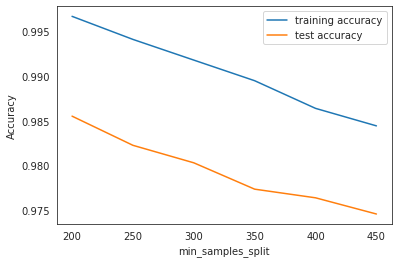

In [95]:
# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [96]:

# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [12,16],
     'n_estimators': [300,400,500], 
    'max_features': [10, 15]
}
# Create a based model
rf = RandomForestClassifier(class_weight='balanced')
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid,refit='recall_score' ,
                          cv = 3, verbose = 1, n_jobs=-1)

In [97]:
# fit
grid_search.fit(X_train_smote,y_train_smote)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  36 out of  36 | elapsed:  4.0min finished


GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced',
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                              oob_score=False,
                                             

In [98]:
# printing the optimal accuracy score and hyperparameters
print('We can get accuracy of',grid_search.best_score_,'using',grid_search.best_params_)

We can get accuracy of 0.8951088495485425 using {'max_depth': 16, 'max_features': 10, 'n_estimators': 500}


In [99]:
# model with the best hyperparameters

rfc_final = RandomForestClassifier(bootstrap=True,class_weight='balanced',
                             max_depth=16,
                             max_features=10,
                             n_estimators=500)

In [100]:
# fit
rfc_final.fit(X_train_smote,y_train_smote)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=16, max_features=10,
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=500,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [101]:
class_balanced_model_fit(X_train_smote, y_train_smote, X_test, y_test,RandomForestClassifier(bootstrap=True,class_weight='balanced',
                             max_depth=16,
                             max_features=10,
                             n_estimators=500))

accuracy of the model:  0.9554187651557545

              precision    recall  f1-score   support

    Negative       0.38      0.44      0.40       185
    Positive       0.98      0.97      0.98      5176

    accuracy                           0.96      5361
   macro avg       0.68      0.71      0.69      5361
weighted avg       0.96      0.96      0.96      5361


ROC_AUC score:  0.9104703621705168


With 5 folds, and applying grid search and tuning multiple parameters like max_depth, min_sample_leaf,n_estimators, max_features we got an accuracy of 95.9 close to 96%, which is still less than our Logistic Regression accuracy, therefore, we consider Logistic Regression as our final model

Lets begin the model prediction now:

In [102]:
def model_pred(X_train, y_train, X_test, y_test, model):
    model = model()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_pred_probs = model.predict_proba(X_test)[:,1]
    return y_pred, y_pred_probs

In [103]:
def ROC_curve_plots(y_test,y_pred_probs1, y_pred_probs2, y_pred_probs3, model1, model2, model3):
    fpr1, tpr1, _ = roc_curve(y_test, y_pred_probs1,pos_label='Positive')
    auc1 = roc_auc_score(y_test, y_pred_probs1)
    fpr2, tpr2, _ = roc_curve(y_test, y_pred_probs2,pos_label='Positive')
    auc2 = roc_auc_score(y_test, y_pred_probs2)
    fpr3, tpr3, _ = roc_curve(y_test, y_pred_probs3,pos_label='Positive')
    auc3 = roc_auc_score(y_test, y_pred_probs3) 
    plt.figure(1,figsize=(12,8))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(fpr1, tpr1, label=f'{model1} AUC={round(auc1,3)}')
    plt.plot(fpr2, tpr2, label=f'{model2} AUC={round(auc2,3)}')
    plt.plot(fpr3, tpr3, label=f'{model3} AUC={round(auc3,3)}')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    return

In [104]:
y_pred1, y_pred_probs1 = model_pred(X_train_smote, y_train_smote, X_test, y_test, LogisticRegression)
y_pred2, y_pred_probs2 = model_pred(X_train_smote, y_train_smote, X_test, y_test, MultinomialNB)
y_pred3, y_pred_probs3 = model_pred(X_train_smote, y_train_smote, X_test, y_test, RandomForestClassifier)

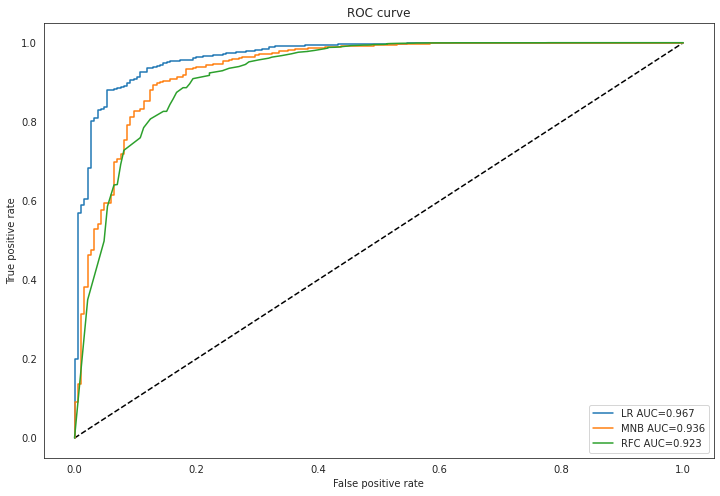

In [105]:

ROC_curve_plots(y_test,y_pred_probs1, y_pred_probs2,y_pred_probs3, 'LR', 'MNB','RFC')

As per the ROC curve, we can see the Logistic Regression has performed best

In [106]:
data.columns

Index(['id', 'name', 'reviews_rating', 'reviews_username', 'user_sentiment',
       'review', 'user_sentiment_pred'],
      dtype='object')

#Building a Recommendation System

Copying the original dataset into recommend df, as we will use name, review_username and rating for the recommendation system

In [107]:
recommend = pd.read_csv("prod_with_pred.csv")

In [108]:
recommend.columns

Index(['id', 'name', 'reviews_rating', 'reviews_username', 'user_sentiment',
       'review', 'user_sentiment_pred'],
      dtype='object')

In [109]:
recommend = recommend[((recommend.reviews_rating>3) & (recommend.user_sentiment=='Negative'))==False]

In [110]:
recommend=recommend[recommend['user_sentiment'].isnull()==False]

In [111]:
recommend = recommend[((recommend.reviews_rating==1) & (recommend.user_sentiment=='Positive'))==False]

In [112]:
recommend['reviews_username']=recommend['reviews_username'].str.lower()
recommend['name']=recommend['name'].str.lower()

In [113]:
recommend.shape

(26802, 7)

In [114]:
recommend.head()

,id,name,reviews_rating,reviews_username,user_sentiment,review,user_sentiment_pred
0,AV13O1A8GV-KLJ3akUyj,pink friday: roman reloaded re-up (w/dvd),5,joshua,Positive,love album good hip hop side current pop sound hype listen everyday gym give star rate way metaphor crazi awesom,Positive
1,AV14LG0R-jtxr-f38QfS,lundberg organic cinnamon toast rice cakes,5,dorothy w,Positive,good flavor good,Positive
2,AV14LG0R-jtxr-f38QfS,lundberg organic cinnamon toast rice cakes,5,dorothy w,Positive,good flavor good,Positive
3,AV16khLE-jtxr-f38VFn,k-y love sensuality pleasure gel,1,rebecca,Negative,read review look buy one coupl lubric ultim disappoint even live review read starter neither boyfriend could notic sort enhanc captiv sensat notic howev messi consist reminisc liquid vaselin difficult clean pleasant especi sinc lack captiv sensat expect disappoint paid much lube use could use normal person lubric less money less mess disappoint,Negative
4,AV16khLE-jtxr-f38VFn,k-y love sensuality pleasure gel,1,walker557,Negative,husband bought gel us gel caus irrit felt like burn skin recommend gel irrit,Negative


Saving the ratings data set after pre processing the data set needed for recommendation system

In [219]:
recommend.to_csv("recommend.csv",index=False)


Till this step the preprocessing of the recommend df is completed and now, we proceed with test and train split

In [115]:
train, test = train_test_split(recommend, test_size=0.30, random_state=31)

In [116]:
print(train.shape)
print(test.shape)

(18761, 7)
(8041, 7)


In [117]:
# Pivot the train ratings' dataset into matrix format in which columns are movies and the rows are user IDs.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(0)

df_pivot.head(3)

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",ambi complexion cleansing bar,annie's homegrown deluxe elbows & four cheese sauce,annie's homegrown gluten free double chocolate chip granola bars,arrid extra dry anti-perspirant deodorant spray regular,"aussie aussome volume shampoo, 13.5 oz","australian gold exotic blend lotion, spf 4","aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55, 4oz",avery174 11-1/4 x 9-1/4 index maker extra wide label dividers with 5 tab - clear (5 sets per pack),"avery174 ready index contemporary table of contents divider, 1-8, multi, letter",axe dry anti-perspirant deodorant invisible solid phoenix,"banana boat sunless summer color self tanning lotion, light to medium",barielle nail rebuilding protein,"batherapy natural mineral bath sport liquid, 16 oz",baxter of california cream pomade,"beanitos bean chips, simply pinto bean",bedtime originals pinkie musical mobile,"ben & jerry's coffee, coffee buzzbuzzbuzz! ice cream, pint","better built 74010862 bet74010862 60in crossover two lid, deep, truck tool box",bi-o-kleen spray & wipe all purpose cleaner,bilbao nightstand gray oak - south shore,bill glor gaither - church in the wildwood (cd),bisquick original pancake and baking mix - 40oz,black front loading frame set (8.5x11) set of 12,boraam sonoma kitchen cart with wire brush gray - maaya home,"bounce dryer sheets, fresh linen, 160 sheets","bridgestone 130/70zr18m/c(63w)front exedra g851, cruiser radl",bumble bee solid white albacore in water - 5 oz,"burt's bees lip shimmer, raisin","burt's bees lip shimmer, watermelon",calvin klein secret obsession eau de parfum,"candy pink plastic cups, 20 pk",...,stander pt bedcane - bed handle,starbucks iced expresso classics vanilla latte coffee beverage - 40oz,starbucks153 doubleshot protein coffee - 11 fl oz,stargate (ws) (ultimate edition) (director's cut) (dvdvideo),"storkcraft tuscany glider and ottoman, beige cushions, espresso finish","suave professionals hair conditioner, sleek",sunflower swag with metal frame - nearly natural,"super poligrip denture adhesive cream, ultra fresh - 2.4 oz",switchmas (dvd),tai pei sweet & sour chicken,the honest company laundry detergent,the resident evil collection 5 discs (blu-ray),the script - no sound without silence (cd),"the seaweed bath co. argan conditioner, smoothing citrus",there's something about mary (dvd),tim holtz retractable craft pick-red 6x.5,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,toy story kids' woody accessory kit,tramontina ceramica 10 piece cookware set - red,"tree hut shea body butters, coconut lime, 7 oz",trend lab park nursing cover - paisley,tresemme kertatin smooth infusing conditioning,various - country's greatest gospel:gold ed (cd),various - red hot blue:tribute to cole porter (cd),various artists - choo choo soul (cd),vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"wallmount server cabinet (450mm, 9 ru)","way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [118]:
df_pivot.shape

(16426, 246)

#Creating dummy train & dummy test dataset
These dataset will be used for prediction

Dummy train will be used later for prediction of the movies which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The movies not rated by user is marked as 1 for prediction in dummy train dataset.

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [119]:
# Copy the train dataset into dummy_train
dummy_train = train.copy()

In [120]:
train.head()

,id,name,reviews_rating,reviews_username,user_sentiment,review,user_sentiment_pred
7734,AVpf3VOfilAPnD_xjpun,clorox disinfecting wipes value pack scented 150 ct total,5,roboca,Positive,clorox disinfect wipe make everyday clean snap great kitchen bathroom make everyday clean snap,Positive
13140,AVpf3VOfilAPnD_xjpun,clorox disinfecting wipes value pack scented 150 ct total,5,daisy1312,Positive,realli love clorox help keep hous clean kid love clorox,Positive
4214,AVpf0eb2LJeJML43EVSt,the resident evil collection 5 discs (blu-ray),4,scotty,Positive,love collect must wish came new movi great collect,Positive
3771,AVpe9W4D1cnluZ0-avf0,hoover174 platinum collection153 lightweight bagged upright vacuum with canister - uh30010com,4,NaN,Positive,awesom suction power complet captur dirt circul home carpet year fill one bag dispos downsid motor fail year own good thing hoover back product year warranti author servic dealer said hoover often time send new one instead repair motor take time hope case effect suction,Positive
18094,AVpfJP1C1cnluZ0-e3Xy,clorox disinfecting bathroom cleaner,5,dmd14,Positive,alway love clean clorox wipe realli love fresh scent wipe great use tile tabletop clean grout freshen smell kitchen use clean entir hous one favorit clean suppli never let run clean great fresh scent,Positive


In [121]:
# The products rated <3 by user is marked as 0, else 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x<3 else 1)

In [122]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(1)

In [123]:
dummy_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16426 entries, 00dog3 to zzz1127
Columns: 246 entries, 0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest to yes to grapefruit rejuvenating body wash
dtypes: float64(246)
memory usage: 31.0+ MB


# User Similarity Matrix

## Using Cosine Similarity

In [124]:
from sklearn.metrics.pairwise import pairwise_distances

# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_pivot, metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[1. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 1. 0. 1.]
 ...
 [0. 0. 1. ... 1. 0. 1.]
 [0. 1. 0. ... 0. 1. 0.]
 [0. 0. 1. ... 1. 0. 1.]]


In [125]:
user_correlation.shape

(16426, 16426)

#Using adjusted Cosine

### Here, we are not removing the NaN values and calculating the mean only for the movies rated by the user

In [126]:
# Create a user-movie matrix.
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
)

In [127]:
df_pivot.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",ambi complexion cleansing bar,annie's homegrown deluxe elbows & four cheese sauce,annie's homegrown gluten free double chocolate chip granola bars,arrid extra dry anti-perspirant deodorant spray regular,"aussie aussome volume shampoo, 13.5 oz","australian gold exotic blend lotion, spf 4","aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55, 4oz",avery174 11-1/4 x 9-1/4 index maker extra wide label dividers with 5 tab - clear (5 sets per pack),"avery174 ready index contemporary table of contents divider, 1-8, multi, letter",axe dry anti-perspirant deodorant invisible solid phoenix,"banana boat sunless summer color self tanning lotion, light to medium",barielle nail rebuilding protein,"batherapy natural mineral bath sport liquid, 16 oz",baxter of california cream pomade,"beanitos bean chips, simply pinto bean",bedtime originals pinkie musical mobile,"ben & jerry's coffee, coffee buzzbuzzbuzz! ice cream, pint","better built 74010862 bet74010862 60in crossover two lid, deep, truck tool box",bi-o-kleen spray & wipe all purpose cleaner,bilbao nightstand gray oak - south shore,bill glor gaither - church in the wildwood (cd),bisquick original pancake and baking mix - 40oz,black front loading frame set (8.5x11) set of 12,boraam sonoma kitchen cart with wire brush gray - maaya home,"bounce dryer sheets, fresh linen, 160 sheets","bridgestone 130/70zr18m/c(63w)front exedra g851, cruiser radl",bumble bee solid white albacore in water - 5 oz,"burt's bees lip shimmer, raisin","burt's bees lip shimmer, watermelon",calvin klein secret obsession eau de parfum,"candy pink plastic cups, 20 pk",...,stander pt bedcane - bed handle,starbucks iced expresso classics vanilla latte coffee beverage - 40oz,starbucks153 doubleshot protein coffee - 11 fl oz,stargate (ws) (ultimate edition) (director's cut) (dvdvideo),"storkcraft tuscany glider and ottoman, beige cushions, espresso finish","suave professionals hair conditioner, sleek",sunflower swag with metal frame - nearly natural,"super poligrip denture adhesive cream, ultra fresh - 2.4 oz",switchmas (dvd),tai pei sweet & sour chicken,the honest company laundry detergent,the resident evil collection 5 discs (blu-ray),the script - no sound without silence (cd),"the seaweed bath co. argan conditioner, smoothing citrus",there's something about mary (dvd),tim holtz retractable craft pick-red 6x.5,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,toy story kids' woody accessory kit,tramontina ceramica 10 piece cookware set - red,"tree hut shea body butters, coconut lime, 7 oz",trend lab park nursing cover - paisley,tresemme kertatin smooth infusing conditioning,various - country's greatest gospel:gold ed (cd),various - red hot blue:tribute to cole porter (cd),various artists - choo choo soul (cd),vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"wallmount server cabinet (450mm, 9 ru)","way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [128]:
### Normalising the rating of the product for each user around 0 mean
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [129]:
df_subtracted.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",ambi complexion cleansing bar,annie's homegrown deluxe elbows & four cheese sauce,annie's homegrown gluten free double chocolate chip granola bars,arrid extra dry anti-perspirant deodorant spray regular,"aussie aussome volume shampoo, 13.5 oz","australian gold exotic blend lotion, spf 4","aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55, 4oz",avery174 11-1/4 x 9-1/4 index maker extra wide label dividers with 5 tab - clear (5 sets per pack),"avery174 ready index contemporary table of contents divider, 1-8, multi, letter",axe dry anti-perspirant deodorant invisible solid phoenix,"banana boat sunless summer color self tanning lotion, light to medium",barielle nail rebuilding protein,"batherapy natural mineral bath sport liquid, 16 oz",baxter of california cream pomade,"beanitos bean chips, simply pinto bean",bedtime originals pinkie musical mobile,"ben & jerry's coffee, coffee buzzbuzzbuzz! ice cream, pint","better built 74010862 bet74010862 60in crossover two lid, deep, truck tool box",bi-o-kleen spray & wipe all purpose cleaner,bilbao nightstand gray oak - south shore,bill glor gaither - church in the wildwood (cd),bisquick original pancake and baking mix - 40oz,black front loading frame set (8.5x11) set of 12,boraam sonoma kitchen cart with wire brush gray - maaya home,"bounce dryer sheets, fresh linen, 160 sheets","bridgestone 130/70zr18m/c(63w)front exedra g851, cruiser radl",bumble bee solid white albacore in water - 5 oz,"burt's bees lip shimmer, raisin","burt's bees lip shimmer, watermelon",calvin klein secret obsession eau de parfum,"candy pink plastic cups, 20 pk",...,stander pt bedcane - bed handle,starbucks iced expresso classics vanilla latte coffee beverage - 40oz,starbucks153 doubleshot protein coffee - 11 fl oz,stargate (ws) (ultimate edition) (director's cut) (dvdvideo),"storkcraft tuscany glider and ottoman, beige cushions, espresso finish","suave professionals hair conditioner, sleek",sunflower swag with metal frame - nearly natural,"super poligrip denture adhesive cream, ultra fresh - 2.4 oz",switchmas (dvd),tai pei sweet & sour chicken,the honest company laundry detergent,the resident evil collection 5 discs (blu-ray),the script - no sound without silence (cd),"the seaweed bath co. argan conditioner, smoothing citrus",there's something about mary (dvd),tim holtz retractable craft pick-red 6x.5,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,toy story kids' woody accessory kit,tramontina ceramica 10 piece cookware set - red,"tree hut shea body butters, coconut lime, 7 oz",trend lab park nursing cover - paisley,tresemme kertatin smooth infusing conditioning,various - country's greatest gospel:gold ed (cd),various - red hot blue:tribute to cole porter (cd),various artists - choo choo soul (cd),vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"wallmount server cabinet (450mm, 9 ru)","way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

### Finding cosine similarity

In [130]:
from sklearn.metrics.pairwise import pairwise_distances

In [131]:
# Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


## Prediction - User User

Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0.

In [132]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [133]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [134]:
user_predicted_ratings.shape

(16426, 246)

In [135]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",ambi complexion cleansing bar,annie's homegrown deluxe elbows & four cheese sauce,annie's homegrown gluten free double chocolate chip granola bars,arrid extra dry anti-perspirant deodorant spray regular,"aussie aussome volume shampoo, 13.5 oz","australian gold exotic blend lotion, spf 4","aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55, 4oz",avery174 11-1/4 x 9-1/4 index maker extra wide label dividers with 5 tab - clear (5 sets per pack),"avery174 ready index contemporary table of contents divider, 1-8, multi, letter",axe dry anti-perspirant deodorant invisible solid phoenix,"banana boat sunless summer color self tanning lotion, light to medium",barielle nail rebuilding protein,"batherapy natural mineral bath sport liquid, 16 oz",baxter of california cream pomade,"beanitos bean chips, simply pinto bean",bedtime originals pinkie musical mobile,"ben & jerry's coffee, coffee buzzbuzzbuzz! ice cream, pint","better built 74010862 bet74010862 60in crossover two lid, deep, truck tool box",bi-o-kleen spray & wipe all purpose cleaner,bilbao nightstand gray oak - south shore,bill glor gaither - church in the wildwood (cd),bisquick original pancake and baking mix - 40oz,black front loading frame set (8.5x11) set of 12,boraam sonoma kitchen cart with wire brush gray - maaya home,"bounce dryer sheets, fresh linen, 160 sheets","bridgestone 130/70zr18m/c(63w)front exedra g851, cruiser radl",bumble bee solid white albacore in water - 5 oz,"burt's bees lip shimmer, raisin","burt's bees lip shimmer, watermelon",calvin klein secret obsession eau de parfum,"candy pink plastic cups, 20 pk",...,stander pt bedcane - bed handle,starbucks iced expresso classics vanilla latte coffee beverage - 40oz,starbucks153 doubleshot protein coffee - 11 fl oz,stargate (ws) (ultimate edition) (director's cut) (dvdvideo),"storkcraft tuscany glider and ottoman, beige cushions, espresso finish","suave professionals hair conditioner, sleek",sunflower swag with metal frame - nearly natural,"super poligrip denture adhesive cream, ultra fresh - 2.4 oz",switchmas (dvd),tai pei sweet & sour chicken,the honest company laundry detergent,the resident evil collection 5 discs (blu-ray),the script - no sound without silence (cd),"the seaweed bath co. argan conditioner, smoothing citrus",there's something about mary (dvd),tim holtz retractable craft pick-red 6x.5,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,toy story kids' woody accessory kit,tramontina ceramica 10 piece cookware set - red,"tree hut shea body butters, coconut lime, 7 oz",trend lab park nursing cover - paisley,tresemme kertatin smooth infusing conditioning,various - country's greatest gospel:gold ed (cd),various - red hot blue:tribute to cole porter (cd),various artists - choo choo soul (cd),vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"wallmount server cabinet (450mm, 9 ru)","way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [136]:
# Take the user ID as input.
user_input = str(input("Enter your user name"))
print(user_input)

Enter your user namealex
alex


In [137]:
user_final_rating.head(2)

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",ambi complexion cleansing bar,annie's homegrown deluxe elbows & four cheese sauce,annie's homegrown gluten free double chocolate chip granola bars,arrid extra dry anti-perspirant deodorant spray regular,"aussie aussome volume shampoo, 13.5 oz","australian gold exotic blend lotion, spf 4","aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55, 4oz",avery174 11-1/4 x 9-1/4 index maker extra wide label dividers with 5 tab - clear (5 sets per pack),"avery174 ready index contemporary table of contents divider, 1-8, multi, letter",axe dry anti-perspirant deodorant invisible solid phoenix,"banana boat sunless summer color self tanning lotion, light to medium",barielle nail rebuilding protein,"batherapy natural mineral bath sport liquid, 16 oz",baxter of california cream pomade,"beanitos bean chips, simply pinto bean",bedtime originals pinkie musical mobile,"ben & jerry's coffee, coffee buzzbuzzbuzz! ice cream, pint","better built 74010862 bet74010862 60in crossover two lid, deep, truck tool box",bi-o-kleen spray & wipe all purpose cleaner,bilbao nightstand gray oak - south shore,bill glor gaither - church in the wildwood (cd),bisquick original pancake and baking mix - 40oz,black front loading frame set (8.5x11) set of 12,boraam sonoma kitchen cart with wire brush gray - maaya home,"bounce dryer sheets, fresh linen, 160 sheets","bridgestone 130/70zr18m/c(63w)front exedra g851, cruiser radl",bumble bee solid white albacore in water - 5 oz,"burt's bees lip shimmer, raisin","burt's bees lip shimmer, watermelon",calvin klein secret obsession eau de parfum,"candy pink plastic cups, 20 pk",...,stander pt bedcane - bed handle,starbucks iced expresso classics vanilla latte coffee beverage - 40oz,starbucks153 doubleshot protein coffee - 11 fl oz,stargate (ws) (ultimate edition) (director's cut) (dvdvideo),"storkcraft tuscany glider and ottoman, beige cushions, espresso finish","suave professionals hair conditioner, sleek",sunflower swag with metal frame - nearly natural,"super poligrip denture adhesive cream, ultra fresh - 2.4 oz",switchmas (dvd),tai pei sweet & sour chicken,the honest company laundry detergent,the resident evil collection 5 discs (blu-ray),the script - no sound without silence (cd),"the seaweed bath co. argan conditioner, smoothing citrus",there's something about mary (dvd),tim holtz retractable craft pick-red 6x.5,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,toy story kids' woody accessory kit,tramontina ceramica 10 piece cookware set - red,"tree hut shea body butters, coconut lime, 7 oz",trend lab park nursing cover - paisley,tresemme kertatin smooth infusing conditioning,various - country's greatest gospel:gold ed (cd),various - red hot blue:tribute to cole porter (cd),various artists - choo choo soul (cd),vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"wallmount server cabinet (450mm, 9 ru)","way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [138]:
d_recommend = user_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d_recommend

name
godzilla 3d includes digital copy ultraviolet 3d/2d blu-ray/dvd                    92.224978
mike dave need wedding dates (dvd + digital)                                       44.923731
the resident evil collection 5 discs (blu-ray)                                     25.516789
planes: fire rescue (2 discs) (includes digital copy) (blu-ray/dvd)                24.856796
my big fat greek wedding 2 (blu-ray + dvd + digital)                               23.731681
red (special edition) (dvdvideo)                                                   13.405850
clorox disinfecting wipes value pack scented 150 ct total                          9.624724 
pendaflex174 divide it up file folder, multi section, letter, assorted, 12/pack    5.518552 
stargate (ws) (ultimate edition) (director's cut) (dvdvideo)                       5.443376 
tostitos bite size tortilla chips                                                  5.243486 
hormel chili, no beans                                           

# Evaluation - User User 

In [139]:
# Find out the common users of test and train dataset.
common = test[test.reviews_username.isin(train.reviews_username)]
common.shape

(1764, 7)

In [140]:
common.head()

,id,name,reviews_rating,reviews_username,user_sentiment,review,user_sentiment_pred
16877,AVpfJP1C1cnluZ0-e3Xy,clorox disinfecting bathroom cleaner,4,hfinns,Positive,excel clean good streak bathroom sink come clean bathroom tub also put bathroom floorlov clean,Positive
24153,AVpfRoqcLJeJML436FqG,"vicks vaporub, regular, 3.53oz",5,lilang8833,Positive,product use infant stuf work amaz love,NaN
23162,AVpfPaoqLJeJML435Xk9,godzilla 3d includes digital copy ultraviolet 3d/2d blu-ray/dvd,5,laura,Positive,movi excel entertain great buy great price godzilla rock,Positive
20960,AVpfPaoqLJeJML435Xk9,godzilla 3d includes digital copy ultraviolet 3d/2d blu-ray/dvd,4,wolfie,Positive,kiju film properli made keep th spirit origin updat stori modern time thing miss comic con promo video kiju god pleas,Positive
18405,AVpfJP1C1cnluZ0-e3Xy,clorox disinfecting bathroom cleaner,5,faye,Positive,alway depend alway great job use properli great product,Positive


In [141]:
# convert into the user-movie matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [142]:
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

In [143]:
df_subtracted.head(1)

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",ambi complexion cleansing bar,annie's homegrown deluxe elbows & four cheese sauce,annie's homegrown gluten free double chocolate chip granola bars,arrid extra dry anti-perspirant deodorant spray regular,"aussie aussome volume shampoo, 13.5 oz","australian gold exotic blend lotion, spf 4","aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55, 4oz",avery174 11-1/4 x 9-1/4 index maker extra wide label dividers with 5 tab - clear (5 sets per pack),"avery174 ready index contemporary table of contents divider, 1-8, multi, letter",axe dry anti-perspirant deodorant invisible solid phoenix,"banana boat sunless summer color self tanning lotion, light to medium",barielle nail rebuilding protein,"batherapy natural mineral bath sport liquid, 16 oz",baxter of california cream pomade,"beanitos bean chips, simply pinto bean",bedtime originals pinkie musical mobile,"ben & jerry's coffee, coffee buzzbuzzbuzz! ice cream, pint","better built 74010862 bet74010862 60in crossover two lid, deep, truck tool box",bi-o-kleen spray & wipe all purpose cleaner,bilbao nightstand gray oak - south shore,bill glor gaither - church in the wildwood (cd),bisquick original pancake and baking mix - 40oz,black front loading frame set (8.5x11) set of 12,boraam sonoma kitchen cart with wire brush gray - maaya home,"bounce dryer sheets, fresh linen, 160 sheets","bridgestone 130/70zr18m/c(63w)front exedra g851, cruiser radl",bumble bee solid white albacore in water - 5 oz,"burt's bees lip shimmer, raisin","burt's bees lip shimmer, watermelon",calvin klein secret obsession eau de parfum,"candy pink plastic cups, 20 pk",...,stander pt bedcane - bed handle,starbucks iced expresso classics vanilla latte coffee beverage - 40oz,starbucks153 doubleshot protein coffee - 11 fl oz,stargate (ws) (ultimate edition) (director's cut) (dvdvideo),"storkcraft tuscany glider and ottoman, beige cushions, espresso finish","suave professionals hair conditioner, sleek",sunflower swag with metal frame - nearly natural,"super poligrip denture adhesive cream, ultra fresh - 2.4 oz",switchmas (dvd),tai pei sweet & sour chicken,the honest company laundry detergent,the resident evil collection 5 discs (blu-ray),the script - no sound without silence (cd),"the seaweed bath co. argan conditioner, smoothing citrus",there's something about mary (dvd),tim holtz retractable craft pick-red 6x.5,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,toy story kids' woody accessory kit,tramontina ceramica 10 piece cookware set - red,"tree hut shea body butters, coconut lime, 7 oz",trend lab park nursing cover - paisley,tresemme kertatin smooth infusing conditioning,various - country's greatest gospel:gold ed (cd),various - red hot blue:tribute to cole porter (cd),various artists - choo choo soul (cd),vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"wallmount server cabinet (450mm, 9 ru)","way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [144]:
user_correlation_df['userId'] = df_subtracted.index
user_correlation_df.set_index('userId',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,16386,16387,16388,16389,16390,16391,16392,16393,16394,16395,16396,16397,16398,16399,16400,16401,16402,16403,16404,16405,16406,16407,16408,16409,16410,16411,16412,16413,16414,16415,16416,16417,16418,16419,16420,16421,16422,16423,16424,16425
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
06stidriver,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
08dallas,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [145]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()


user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)]

In [146]:
user_correlation_df_1.shape

(1490, 16426)

In [147]:
user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)]

In [148]:
user_correlation_df_3 = user_correlation_df_2.T

In [149]:
user_correlation_df_3.head()

,1234,37f5p,4djs,7inthenest,aac06002,aaron,abbey,abby,abc,abcdefghij,abigail,abismomy,ac94,adam,adma2,adriana9999,adrienne,afwifey2003,ah78,aimee,aisha,aj2012,ajackson75,ajay,ajune,aktcharlotte,alex,alexis,alisonr,alix p,allen,allie,ally,ally1989,alredhouse,aluns,amanda,amazing,amgo2,ami35,...,victoria harris,victoria354235,viking80,vikki,vivian,vkay,voxemluth,vreal88,vypkf0,wally,walt,want297z,wasabi42,wendy,wernigcourtney,wildchild23,wildclay12,wildman,willy,wimbly,wizard,wjb1,wolfie,wolvarine,wonderwoman,woody,woohoo,wowwie,xlivayy,xmom,xstr8edgex,yeya,yeyo,yohnie1,yorkielvr,yummy,yvonne,zapman,zipper,zxcsdfd
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4djs,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7inthenest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
aac06002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [150]:
user_correlation_df_3.shape

(1490, 1490)

In [151]:
user_correlation_df_3[user_correlation_df_3<0]=0

common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings


array([[0.        , 0.        , 0.        , ..., 0.        , 2.06454605,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [152]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=3 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').fillna(0)

In [153]:
dummy_test.shape

(1490, 119)

In [154]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)

In [155]:
common_user_predicted_ratings.head(2)

name,100:complete first season (blu-ray),"42 dual drop leaf table with 2 madrid chairs""",alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",arrid extra dry anti-perspirant deodorant spray regular,"australian gold exotic blend lotion, spf 4","aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55, 4oz","avery174 ready index contemporary table of contents divider, 1-8, multi, letter",axe dry anti-perspirant deodorant invisible solid phoenix,"banana boat sunless summer color self tanning lotion, light to medium","ben & jerry's coffee, coffee buzzbuzzbuzz! ice cream, pint","better built 74010862 bet74010862 60in crossover two lid, deep, truck tool box",bisquick original pancake and baking mix - 40oz,boraam sonoma kitchen cart with wire brush gray - maaya home,"bounce dryer sheets, fresh linen, 160 sheets","bridgestone 130/70zr18m/c(63w)front exedra g851, cruiser radl",bumble bee solid white albacore in water - 5 oz,"burt's bees lip shimmer, raisin",cantu coconut milk shine hold mist - 8oz,care free curl gold instant activator,"caress moisturizing body bar natural silk, 4.75oz",cars toon: mater's tall tales,"cetaphil gentle skin cleanser, 2oz",cheetos crunchy flamin' hot cheese flavored snacks,chester's cheese flavored puffcorn snacks,chex muddy buddies brownie supreme snack mix,chips ahoy! original chocolate chip - cookies - family size 18.2oz,chips deluxe soft 'n chewy cookies,chobani174 strawberry on the bottom non-fat greek yogurt - 5.3oz,clear scalp & hair therapy total care nourishing shampoo,clorox disinfecting bathroom cleaner,clorox disinfecting wipes value pack scented 150 ct total,"coty airspun face powder, translucent extra coverage","creme of nature intensive conditioning treatment, 32",cuisinart174 electric juicer - stainless steel cje-1000,d-con mice bait station - 3ct,dark shadows (includes digital copy) (ultraviolet) (dvdvideo),delta single handle shower faucet,diet canada dry ginger ale - 12pk/12 fl oz cans,doc mcstuffins: friendship is the best medicine,...,"pendaflex174 divide it up file folder, multi section, letter, assorted, 12/pack","physicians formula mineral wear talc-free mineral correcting powder, creamy natural","physicians formula powder palette mineral glow pearls, translucent pearl",planes: fire rescue (2 discs) (includes digital copy) (blu-ray/dvd),"pleasant hearth 1,800 sq ft wood burning stove with blower, medium, lws-127201","pleasant hearth 7.5 steel grate, 30 5 bar - black",pleasant hearth diamond fireplace screen - espresso,post bound jumbo album - burgundy (11x14),power crunch protein energy bar peanut butter creme original,ragu roasted garlic parmesan pasta sauce,ragu traditional pasta sauce,red (special edition) (dvdvideo),romantic drama: greatest classic films collection 2 discs,sabre 2 pack door and window alarm,solo foods poppy seed cake and pastry filling,soothing touch lemon cardamom vegan lip balm .25 oz,sopranos:season 6 part 1 (blu-ray),spam single classic,stacy's simply naked bagel chips,stander pt bedcane - bed handle,stargate (ws) (ultimate edition) (director's cut) (dvdvideo),"suave professionals hair conditioner, sleek",switchmas (dvd),tai pei sweet & sour chicken,the honest company laundry detergent,the resident evil collection 5 discs (blu-ray),the script - no sound without silence (cd),"the seaweed bath co. argan conditioner, smoothing citrus",there's something about mary (dvd),tostitos bite size tortilla chips,tostitos simply blue corn tortilla chips,"tree hut shea body butters, coconut lime, 7 oz",trend lab park nursing cover - paisley,tresemme kertatin smooth infusing conditioning,various artists - choo choo soul (cd),vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1

Calculating the RMSE for only the movies rated by user. For RMSE, normalising the rating to (1,5) range.

In [156]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_user_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [157]:
common_ = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating')

In [158]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [159]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.6839519259615034


#Saving the Model

In [160]:
import pickle
file_name = "Recommendation.pkl"
pickle.dump(user_final_rating, open(file_name, "wb"))

## Using Item similarity

# Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different products. In the user based similarity, we had taken mean for each user instead of each product. 

In [161]:
df_pivot = train.pivot_table(
    index='reviews_username',
    columns='name',
    values='reviews_rating'
).fillna(0).T

df_pivot.head()

reviews_username,00dog3,00sab00,0325home,06stidriver,08dallas,09mommy11,1.11e+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123too,12cass12,12gage,13ld,13ram,1421nikki,143st,148maine,1515,1616,170361eggs,1753,17roses,1863philly,1943,1968bear,1992firebirdgirl,19granny,1awesome1,1buzymom,...,zero,zetamom,zfem2,ziana,zibber23,zibby4,ziggy,zillanator,zinnian,zipp,zipper,zipperdoo,zippity,zippy,zitro,zman69,zmikez,zmom,zoe1988,zoey,zokhid,zombie,zombiejess,zombiekiller,zombiekiller14,zoney86,zookeeper,zotox,zowie,zozo0o,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:complete first season (blu-ray),0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x ultra era with oxi booster, 50fl oz",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4c grated parmesan cheese 100% natural 8oz shaker,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [162]:
df_pivot.shape

(246, 16426)

Normalising the product rating for each product for using the Adujsted Cosine

In [163]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [164]:
df_subtracted.head()

reviews_username,00dog3,00sab00,0325home,06stidriver,08dallas,09mommy11,1.11e+24,1085,10ten,11111111aaaaaaaaaaaaaaaaa,1143mom,11677j,1234,1234561,1234567,1234asdf,123cat123,123charlie,123numbers,123rs,123too,12cass12,12gage,13ld,13ram,1421nikki,143st,148maine,1515,1616,170361eggs,1753,17roses,1863philly,1943,1968bear,1992firebirdgirl,19granny,1awesome1,1buzymom,...,zero,zetamom,zfem2,ziana,zibber23,zibby4,ziggy,zillanator,zinnian,zipp,zipper,zipperdoo,zippity,zippy,zitro,zman69,zmikez,zmom,zoe1988,zoey,zokhid,zombie,zombiejess,zombiekiller,zombiekiller14,zoney86,zookeeper,zotox,zowie,zozo0o,zsazsa,zt313,zubb,zulaa118,zuttle,zwithanx,zxcsdfd,zxjki,zzdiane,zzz1127
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,...,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278,-0.001278
100:complete first season (blu-ray),-0.025813,-0.025813,-0.025813,-0.025813,4.974187,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,...,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813,-0.025813
2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,...,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304
"2x ultra era with oxi booster, 50fl oz",-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,...,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.000304,-0.

In [165]:
df_subtracted.shape

(246, 16426)

Finding the cosine similarity using pairwise distances approach

In [166]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[ 1.00000000e+00 -1.25174435e-03 -1.32593403e-04 ... -1.66341107e-03
  -8.89282300e-04 -6.60838879e-04]
 [-1.25174435e-03  1.00000000e+00 -5.74762394e-04 ... -4.32278556e-03
  -3.85483750e-03 -2.86458697e-03]
 [-1.32593403e-04 -5.74762394e-04  1.00000000e+00 ... -7.63787048e-04
  -4.08331000e-04 -3.03436828e-04]
 ...
 [-1.66341107e-03 -4.32278556e-03 -7.63787048e-04 ...  1.00000000e+00
  -5.12259498e-03 -3.80667638e-03]
 [-8.89282300e-04 -3.85483750e-03 -4.08331000e-04 ... -5.12259498e-03
   1.00000000e+00 -2.03510124e-03]
 [-6.60838879e-04 -2.86458697e-03 -3.03436828e-04 ... -3.80667638e-03
  -2.03510124e-03  1.00000000e+00]]


Filtering the correlation only for which the value is greater than 0. (Positively correlated)

In [167]:
item_correlation[item_correlation<0]=0
item_correlation

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

# Prediction - Item Item

In [168]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00223623],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.00372705],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [169]:
item_predicted_ratings.shape

(16426, 246)

In [170]:
dummy_train.shape

(16426, 246)

### Filtering the rating only for the products not rated by the user for recommendation

In [171]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()

name,0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,100:complete first season (blu-ray),2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,"2x ultra era with oxi booster, 50fl oz",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alberto vo5 salon series smooth plus sleek shampoo,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",ambi complexion cleansing bar,annie's homegrown deluxe elbows & four cheese sauce,annie's homegrown gluten free double chocolate chip granola bars,arrid extra dry anti-perspirant deodorant spray regular,"aussie aussome volume shampoo, 13.5 oz","australian gold exotic blend lotion, spf 4","aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55, 4oz",avery174 11-1/4 x 9-1/4 index maker extra wide label dividers with 5 tab - clear (5 sets per pack),"avery174 ready index contemporary table of contents divider, 1-8, multi, letter",axe dry anti-perspirant deodorant invisible solid phoenix,"banana boat sunless summer color self tanning lotion, light to medium",barielle nail rebuilding protein,"batherapy natural mineral bath sport liquid, 16 oz",baxter of california cream pomade,"beanitos bean chips, simply pinto bean",bedtime originals pinkie musical mobile,"ben & jerry's coffee, coffee buzzbuzzbuzz! ice cream, pint","better built 74010862 bet74010862 60in crossover two lid, deep, truck tool box",bi-o-kleen spray & wipe all purpose cleaner,bilbao nightstand gray oak - south shore,bill glor gaither - church in the wildwood (cd),bisquick original pancake and baking mix - 40oz,black front loading frame set (8.5x11) set of 12,boraam sonoma kitchen cart with wire brush gray - maaya home,"bounce dryer sheets, fresh linen, 160 sheets","bridgestone 130/70zr18m/c(63w)front exedra g851, cruiser radl",bumble bee solid white albacore in water - 5 oz,"burt's bees lip shimmer, raisin","burt's bees lip shimmer, watermelon",calvin klein secret obsession eau de parfum,"candy pink plastic cups, 20 pk",...,stander pt bedcane - bed handle,starbucks iced expresso classics vanilla latte coffee beverage - 40oz,starbucks153 doubleshot protein coffee - 11 fl oz,stargate (ws) (ultimate edition) (director's cut) (dvdvideo),"storkcraft tuscany glider and ottoman, beige cushions, espresso finish","suave professionals hair conditioner, sleek",sunflower swag with metal frame - nearly natural,"super poligrip denture adhesive cream, ultra fresh - 2.4 oz",switchmas (dvd),tai pei sweet & sour chicken,the honest company laundry detergent,the resident evil collection 5 discs (blu-ray),the script - no sound without silence (cd),"the seaweed bath co. argan conditioner, smoothing citrus",there's something about mary (dvd),tim holtz retractable craft pick-red 6x.5,tostitos bite size tortilla chips,tostitos original restaurant style tortilla chips,tostitos simply blue corn tortilla chips,toy story kids' woody accessory kit,tramontina ceramica 10 piece cookware set - red,"tree hut shea body butters, coconut lime, 7 oz",trend lab park nursing cover - paisley,tresemme kertatin smooth infusing conditioning,various - country's greatest gospel:gold ed (cd),various - red hot blue:tribute to cole porter (cd),various artists - choo choo soul (cd),vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,wagan smartac 80watt inverter with usb,walkers stem ginger shortbread,"wallmount server cabinet (450mm, 9 ru)","way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [172]:
item_final_rating.shape

(16426, 246)

In [173]:
# Take the user ID as input
user_input = input("Enter your user name")
print(user_input)

Enter your user namealex
alex


In [174]:
# Recommending the Top 5 products to the user.
d_recommend = item_final_rating.loc[user_input].sort_values(ascending=False)[0:20]
d_recommend

name
godzilla 3d includes digital copy ultraviolet 3d/2d blu-ray/dvd                                            4.500000
mike dave need wedding dates (dvd + digital)                                                               3.000000
ceiling fan with light white 14.2 x 29.9 x 9.2 - hunter fan                                                0.149020
the seaweed bath co. argan conditioner, smoothing citrus                                                   0.116206
feit 60-watt a19 gu24 base led light bulb - soft white                                                     0.107163
noosa honey yogurt                                                                                         0.104859
progresso traditional chicken rice with vegetables soup                                                    0.104859
newman's own balsamic vinaigrette, 16.0oz                                                                  0.090429
various - country's greatest gospel:gold ed (cd)                   

# Evaluation - Item Item

In [175]:
test.columns

Index(['id', 'name', 'reviews_rating', 'reviews_username', 'user_sentiment',
       'review', 'user_sentiment_pred'],
      dtype='object')

In [176]:
print(test.shape)
print(train.shape)

(8041, 7)
(18761, 7)


In [177]:
common =  test[test.name.isin(train.name)]
common.shape

(8019, 7)

In [178]:
common[common['name']=='tramontina ceramica 10 piece cookware set - red']

,id,name,reviews_rating,reviews_username,user_sentiment,review,user_sentiment_pred
16410,AVpfEqFbilAPnD_xUV28,tramontina ceramica 10 piece cookware set - red,5,NaN,Positive,love cookwar non stick made itali sure follow season direct use use high heat reward easi cook cleanup great cookwar,Positive


In [179]:
common.loc[common.name == "tramontina ceramica 10 piece cookware set - red", "reviews_username"] = "Anonymous"

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1763: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value)


In [180]:
common[common['name']=='tramontina ceramica 10 piece cookware set - red']

,id,name,reviews_rating,reviews_username,user_sentiment,review,user_sentiment_pred
16410,AVpfEqFbilAPnD_xUV28,tramontina ceramica 10 piece cookware set - red,5,Anonymous,Positive,love cookwar non stick made itali sure follow season direct use use high heat reward easi cook cleanup great cookwar,Positive


In [181]:
common.head(4)

,id,name,reviews_rating,reviews_username,user_sentiment,review,user_sentiment_pred
13982,AVpf5Z1zLJeJML43FpB-,"lysol concentrate deodorizing cleaner, original scent",2,mrsjennings,Negative,smell bad make hous stankbad smell,Positive
16586,AVpfiUrfLJeJML43-9nY,delta single handle shower faucet,5,ellen307,Positive,nice look set tell instal hope soon delta hous use delta love work greaton broke speakman part cost cartridgenic lookin gshower set,Positive
2767,AVpe59io1cnluZ0-ZgDU,my big fat greek wedding 2 (blu-ray + dvd + digital),5,manda88,Positive,great movi watch entertain think watchinggreat movi,Positive
6641,AVpf3VOfilAPnD_xjpun,clorox disinfecting wipes value pack scented 150 ct total,4,cleaningmachine1234,Positive,great product love use kitchen counter great,Positive


In [182]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T

In [183]:
common_item_based_matrix.shape

(189, 7489)

In [184]:
common_item_based_matrix.head()

reviews_username,01impala,02dakota,02deuce,1234,123soccermom,127726,13dani,13thfaerie,15425shopper,18612,1979edes,19bubba67,1boomer,1gussy,1jodie,1movielover2,1sonny,1sttimemama,1texasmom,1witch,2011pink2011,2013bestbuyer,2016parker10,2062351337,210tundra,21please,232323,24hrstoneroses,2689,2bgreen,2big,2busy4u,2dobies,2hearts1love,2sweetdaisies,2total,30103,3276teev,37f5p,3dcav,...,yeyo,yogip,yohnie1,yolanda,yolita,yoolie,yopack,yorkielvr,ythelastman89,yummy,yvonne,yyz2112123,zak,zakkwylde29,zanay,zapman,zarah,zeek09,zegan,zenmon,zeroonec,zhio,zhjwpp,zhynellebb,zillafan,zina911,zipper,zkondrk,znxfyt,zod10,zoeellasca,zoeyny,zombiegirl22,zone,zooey_57,zoomin76,zoso60,zpalma,zxcsdfd,zyiah4
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100:complete first season (blu-ray),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
"2x ultra era with oxi booster, 50fl oz",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4c grated parmesan cheese 100% natural 8oz shaker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
africa's best no-lye dual conditioning relaxer system super,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
alex cross (dvdvideo),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [185]:
item_correlation_df = pd.DataFrame(item_correlation)

In [186]:
item_correlation_df.shape

(246, 246)

In [187]:
item_correlation_df.head(1)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.141839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [188]:
item_correlation_df['name'] = df_subtracted.index
item_correlation_df.set_index('name',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0.6 cu. ft. letter a4 size waterproof 30 min. fire file chest,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.141839,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
100:complete first season (blu-ray),0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.077914,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.004016,0.0,0.0,0.0,0.0,0.0,0.0,0.034375,0.00721,0.0,0.0,0.0,0.0,0.000569,0.0,0.0,0.0,0.0,0.0,0.0,0.017249,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-2018 brownline174 duraflex 14-month planner 8 1/2 x 11 black,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"2x ultra era with oxi booster, 50fl oz",0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4c grated parmesan cheese 100% natural 8oz shaker,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [189]:
item_correlation_df.shape

(246, 246)

In [190]:
list_name = common.name.tolist()

In [191]:
len(list_name)

8019

In [192]:
item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

In [193]:
item_correlation_df_1.shape


(189, 246)

In [194]:
item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]
print(item_correlation_df_2.shape)

item_correlation_df_3 = item_correlation_df_2.T

(189, 189)


In [195]:
item_correlation_df_3.head()

,100:complete first season (blu-ray),"2x ultra era with oxi booster, 50fl oz",4c grated parmesan cheese 100% natural 8oz shaker,africa's best no-lye dual conditioning relaxer system super,alex cross (dvdvideo),"all,bran complete wheat flakes, 18 oz.",annie's homegrown gluten free double chocolate chip granola bars,arrid extra dry anti-perspirant deodorant spray regular,"aussie aussome volume shampoo, 13.5 oz","australian gold exotic blend lotion, spf 4","aveeno baby continuous protection lotion sunscreen with broad spectrum spf 55, 4oz","avery174 ready index contemporary table of contents divider, 1-8, multi, letter",axe dry anti-perspirant deodorant invisible solid phoenix,"banana boat sunless summer color self tanning lotion, light to medium",barielle nail rebuilding protein,baxter of california cream pomade,"beanitos bean chips, simply pinto bean","ben & jerry's coffee, coffee buzzbuzzbuzz! ice cream, pint","better built 74010862 bet74010862 60in crossover two lid, deep, truck tool box",bi-o-kleen spray & wipe all purpose cleaner,bilbao nightstand gray oak - south shore,bisquick original pancake and baking mix - 40oz,black front loading frame set (8.5x11) set of 12,boraam sonoma kitchen cart with wire brush gray - maaya home,"bounce dryer sheets, fresh linen, 160 sheets","bridgestone 130/70zr18m/c(63w)front exedra g851, cruiser radl",bumble bee solid white albacore in water - 5 oz,"burt's bees lip shimmer, raisin","burt's bees lip shimmer, watermelon",cantu coconut milk shine hold mist - 8oz,care free curl gold instant activator,"caress moisturizing body bar natural silk, 4.75oz",cars toon: mater's tall tales,cerave sa renewing cream,"cetaphil gentle skin cleanser, 2oz",charcoal stone toothbrush holder gray,cheetos crunchy flamin' hot cheese flavored snacks,chester's cheese flavored puffcorn snacks,chex muddy buddies brownie supreme snack mix,chips ahoy! original chocolate chip - cookies - family size 18.2oz,...,sizzix framelits dies 1by tim holtz bird crazy-silver asst sizes,"smead174 2 1/4 inch accordion expansion wallet, poly, letter, translucent green","smead174 recycled letter size manila file backs w/prong fasteners, 2 capacity, 100/box",solo foods almond paste,solo foods poppy seed cake and pastry filling,soothing touch lemon cardamom vegan lip balm .25 oz,sopranos:season 6 part 1 (blu-ray),spam single classic,stacy's garden veggie medley pita chips,stacy's simply naked bagel chips,stander pt bedcane - bed handle,starbucks iced expresso classics vanilla latte coffee beverage - 40oz,stargate (ws) (ultimate edition) (director's cut) (dvdvideo),"storkcraft tuscany glider and ottoman, beige cushions, espresso finish","suave professionals hair conditioner, sleek","super poligrip denture adhesive cream, ultra fresh - 2.4 oz",switchmas (dvd),tai pei sweet & sour chicken,the honest company laundry detergent,the resident evil collection 5 discs (blu-ray),the script - no sound without silence (cd),"the seaweed bath co. argan conditioner, smoothing citrus",there's something about mary (dvd),tostitos bite size tortilla chips,tostitos simply blue corn tortilla chips,tramontina ceramica 10 piece cookware set - red,"tree hut shea body butters, coconut lime, 7 oz",trend lab park nursing cover - paisley,tresemme kertatin smooth infusing conditioning,various artists - choo choo soul (cd),vaseline intensive care healthy hands stronger nails,vaseline intensive care lip therapy cocoa butter,"vicks vaporub, regular, 3.53oz",voortman sugar free fudge chocolate chip cookies,"way basics 3-shelf eco narrow bookcase storage shelf, espresso - formaldehyde free - lifetime guarantee","weathertech 40647 14-15 outlander cargo liners behind 2nd row, black",weleda everon lip balm,windex original glass cleaner refill 67.6oz (2 liter),yes to carrots nourishing body wash,yes to grapefruit rejuvenating body wash
name,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
100:complete first season (blu-ray),1.0,0.0,0.0,0.0,0.0,0.

In [196]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [197]:
common_item_predicted_ratings.shape

(189, 7489)

In [198]:
dummy_test = common.copy()

dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=3 else 0)

dummy_test = dummy_test.pivot_table(index='reviews_username', columns='name', values='reviews_rating').T.fillna(0)

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)

In [199]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

In [200]:
from sklearn.preprocessing import MinMaxScaler
from numpy import *

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(copy=True, feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:375: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:376: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [201]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

In [202]:
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

0.06515919819330683


## The RMSE of user based recommendation is lower than item based recommendation .Hence the user based recommendation engine is better.

The Rating file contains the predicted sentiment based on LOGISTIC REGRESSION .The recommendation.pkl file contains the model for recommendation based on user id.The recommended system recommend 20 movies id, and based on that top 5 are selected from ratings data frame on the basis of sentiment

In [203]:
file_name = "Recommendation.pkl"
Recommendation_loaded = pickle.load(open(file_name, "rb"))

In [204]:
recommend.head()

,id,name,reviews_rating,reviews_username,user_sentiment,review,user_sentiment_pred
0,AV13O1A8GV-KLJ3akUyj,pink friday: roman reloaded re-up (w/dvd),5,joshua,Positive,love album good hip hop side current pop sound hype listen everyday gym give star rate way metaphor crazi awesom,Positive
1,AV14LG0R-jtxr-f38QfS,lundberg organic cinnamon toast rice cakes,5,dorothy w,Positive,good flavor good,Positive
2,AV14LG0R-jtxr-f38QfS,lundberg organic cinnamon toast rice cakes,5,dorothy w,Positive,good flavor good,Positive
3,AV16khLE-jtxr-f38VFn,k-y love sensuality pleasure gel,1,rebecca,Negative,read review look buy one coupl lubric ultim disappoint even live review read starter neither boyfriend could notic sort enhanc captiv sensat notic howev messi consist reminisc liquid vaselin difficult clean pleasant especi sinc lack captiv sensat expect disappoint paid much lube use could use normal person lubric less money less mess disappoint,Negative
4,AV16khLE-jtxr-f38VFn,k-y love sensuality pleasure gel,1,walker557,Negative,husband bought gel us gel caus irrit felt like burn skin recommend gel irrit,Negative


In [205]:
# Take the user ID as input
user_input = input("Enter your user name")
print(user_input)

Enter your user namealex
alex


In [206]:
# Recommending the Top 20 products to the user.
d = Recommendation_loaded.loc[user_input].sort_values(ascending=False)[0:20]
d

name
godzilla 3d includes digital copy ultraviolet 3d/2d blu-ray/dvd                    92.224978
mike dave need wedding dates (dvd + digital)                                       44.923731
the resident evil collection 5 discs (blu-ray)                                     25.516789
planes: fire rescue (2 discs) (includes digital copy) (blu-ray/dvd)                24.856796
my big fat greek wedding 2 (blu-ray + dvd + digital)                               23.731681
red (special edition) (dvdvideo)                                                   13.405850
clorox disinfecting wipes value pack scented 150 ct total                          9.624724 
pendaflex174 divide it up file folder, multi section, letter, assorted, 12/pack    5.518552 
stargate (ws) (ultimate edition) (director's cut) (dvdvideo)                       5.443376 
tostitos bite size tortilla chips                                                  5.243486 
hormel chili, no beans                                           

In [207]:
list = d.to_frame().reset_index().name.to_list()
print(list)
ratings_top=recommend[recommend['name'].apply(lambda x:x in list)]
ratings_top.head(1)

['godzilla 3d includes digital copy ultraviolet 3d/2d blu-ray/dvd', 'mike dave need wedding dates (dvd + digital)', 'the resident evil collection 5 discs (blu-ray)', 'planes: fire rescue (2 discs) (includes digital copy) (blu-ray/dvd)', 'my big fat greek wedding 2 (blu-ray + dvd + digital)', 'red (special edition) (dvdvideo)', 'clorox disinfecting wipes value pack scented 150 ct total', 'pendaflex174 divide it up file folder, multi section, letter, assorted, 12/pack', "stargate (ws) (ultimate edition) (director's cut) (dvdvideo)", 'tostitos bite size tortilla chips', 'hormel chili, no beans', "meguiar's ultimate quik detailer 22-oz.", 'clorox disinfecting bathroom cleaner', 'alex cross (dvdvideo)', 'clear scalp & hair therapy total care nourishing shampoo', "there's something about mary (dvd)", 'dark shadows (includes digital copy) (ultraviolet) (dvdvideo)', 'bisquick original pancake and baking mix - 40oz', '100:complete first season (blu-ray)', 'hawaiian punch berry limeade blast jui

,id,name,reviews_rating,reviews_username,user_sentiment,review,user_sentiment_pred
1341,AVpe31o71cnluZ0-YrSD,dark shadows (includes digital copy) (ultraviolet) (dvdvideo),1,craigr,Negative,suppos disc item one disc case case spot one dvd could put dvd want poor market even receipt said disc wast ga drive back store return get thing actual disc one purchas pottstown pa store maryland exchang bad,Positive


In [208]:

ratings_top.user_sentiment_pred=ratings_top.user_sentiment_pred.apply(lambda x:0 if x=='Negative' else 1)

/usr/local/lib/python3.7/dist-packages/pandas/core/generic.py:5170: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


The count method , calculated the sentiment in terms of percentage , and then top 5 movies id are selected based on sentiment

In [209]:
list_perc=[]
def count(df):
  for x in list:
    list2=[x]
    dummy_frame=ratings_top[ratings_top.name.apply(lambda x:x  in list2)]
    deno=len(dummy_frame)
    num=dummy_frame.user_sentiment_pred.sum()
    list_perc.append(round(num/deno,3))

In [210]:
count(ratings_top)
list_perc

[0.943,
 0.96,
 0.983,
 1.0,
 0.971,
 0.959,
 0.992,
 0.96,
 1.0,
 0.978,
 1.0,
 1.0,
 0.709,
 0.983,
 0.992,
 1.0,
 0.778,
 0.976,
 0.992,
 1.0]

In [211]:
temp=d.to_frame()
temp['Sentiment_percent']=list_perc

In [212]:
top5_list = temp.Sentiment_percent.sort_values(ascending=False)[0:5].to_frame().reset_index().name.to_list()
top5_list

['hawaiian punch berry limeade blast juice',
 "stargate (ws) (ultimate edition) (director's cut) (dvdvideo)",
 'planes: fire rescue (2 discs) (includes digital copy) (blu-ray/dvd)',
 "there's something about mary (dvd)",
 "meguiar's ultimate quik detailer 22-oz."]

#Printing the 5 Recommended Products based on sentiment

In [213]:
product_recommended=set(ratings_top[ratings_top['name'].apply(lambda x:x in top5_list)].name.tolist())
product_recommended

{'hawaiian punch berry limeade blast juice',
 "meguiar's ultimate quik detailer 22-oz.",
 'planes: fire rescue (2 discs) (includes digital copy) (blu-ray/dvd)',
 "stargate (ws) (ultimate edition) (director's cut) (dvdvideo)",
 "there's something about mary (dvd)"}

#Downloading the necesary files

In [216]:
from google.colab import files
files.download('Recommendation.pkl')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [217]:
files.download('prod_with_pred.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [220]:
files.download('recommend.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>